1. Summarize the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('FEDFUNDS.csv')

In [3]:
data['DATE'] = pd.to_datetime(data['DATE'])

# Check for missing data
missing_data = data.isnull().sum()

# Calculate the number of observations
num_observations = len(data)

# Calculate the range of dates
start_date = data['DATE'].min()
end_date = data['DATE'].max()
date_range = (end_date - start_date).days

# Calculate the mean, median, and standard deviation
mean_rate = data['FEDFUNDS'].mean()
median_rate = data['FEDFUNDS'].median()
std_deviation = data['FEDFUNDS'].std()

# Identify the minimum and maximum rates and their corresponding dates
min_rate = data['FEDFUNDS'].min()
max_rate = data['FEDFUNDS'].max()
min_rate_date = data.loc[data['FEDFUNDS'].idxmin()]['DATE']
max_rate_date = data.loc[data['FEDFUNDS'].idxmax()]['DATE']

# Display the data summary
print("Data Summary:")
for column, count in missing_data.items():
    print(f"Missing data in {column}: {count}")
print(f"Number of Observations: {num_observations}")
print(f"Time Period Covered: {date_range} days")
print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")
print(f"Mean Federal Funds Rate: {mean_rate:.2f}%")
print(f"Median Federal Funds Rate: {median_rate:.2f}%")
print(f"Standard Deviation: {std_deviation:.2f}")
print(f"Minimum Federal Funds Rate: {min_rate:.2f}% (Date: {min_rate_date})")
print(f"Maximum Federal Funds Rate: {max_rate:.2f}% (Date: {max_rate_date})")

Data Summary:
Missing data in DATE: 0
Missing data in FEDFUNDS: 0
Number of Observations: 831
Time Period Covered: 25264 days
Start Date: 1954-07-01 00:00:00
End Date: 2023-09-01 00:00:00
Mean Federal Funds Rate: 4.60%
Median Federal Funds Rate: 4.16%
Standard Deviation: 3.60
Minimum Federal Funds Rate: 0.05% (Date: 2020-04-01 00:00:00)
Maximum Federal Funds Rate: 19.10% (Date: 1981-06-01 00:00:00)


2. Visualize the data

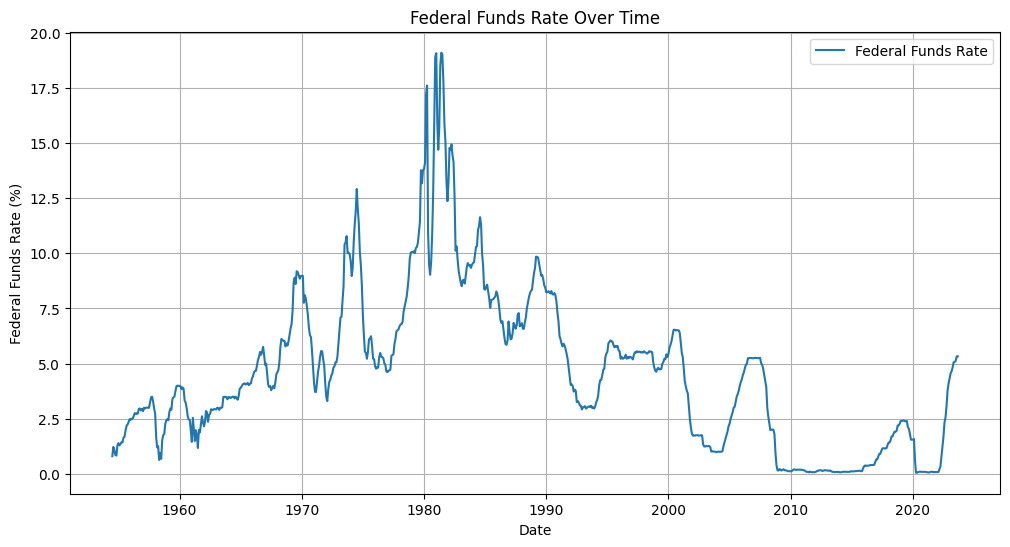

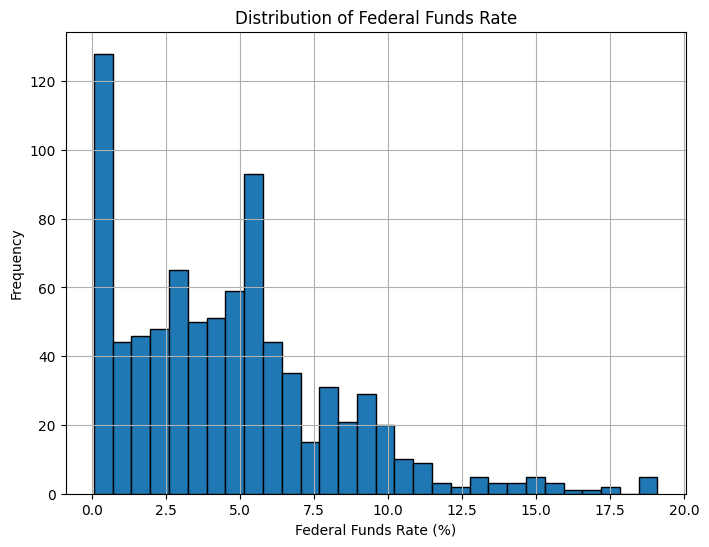

In [4]:
# Data Visualization (Time Series Plot)
plt.figure(figsize=(12, 6))
plt.plot(data['DATE'], data['FEDFUNDS'], label='Federal Funds Rate')
plt.title('Federal Funds Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Federal Funds Rate (%)')
plt.grid(True)
plt.legend()
plt.show()

# Data Distribution (Histogram)
plt.figure(figsize=(8, 6))
plt.hist(data['FEDFUNDS'], bins=30, edgecolor='k')
plt.title('Distribution of Federal Funds Rate')
plt.xlabel('Federal Funds Rate (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


3. Is the data stationary? Is there any seasonality in data?
How is Autocorelation function and Partial Auto corellation?

In [5]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

In [6]:
# The Augmented Dickey-Fuller (ADF) test is used to check for stationarity.
def adf_test(series):
    print('ADF Statistic: %f' % adfuller(series)[0])
    print('p-value: %f' % adfuller(series)[1])
    print('Critical Values:')
    for key, value in adfuller(series)[4].items():
        print('\t%s: %.3f' % (key, value))
    if adfuller(series)[1] < 0.05:
        print("The data is stationary.")
    else:
        print("The data is not stationary.")

adf_test(data['FEDFUNDS'])

ADF Statistic: -2.950543
p-value: 0.039778
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
The data is stationary.


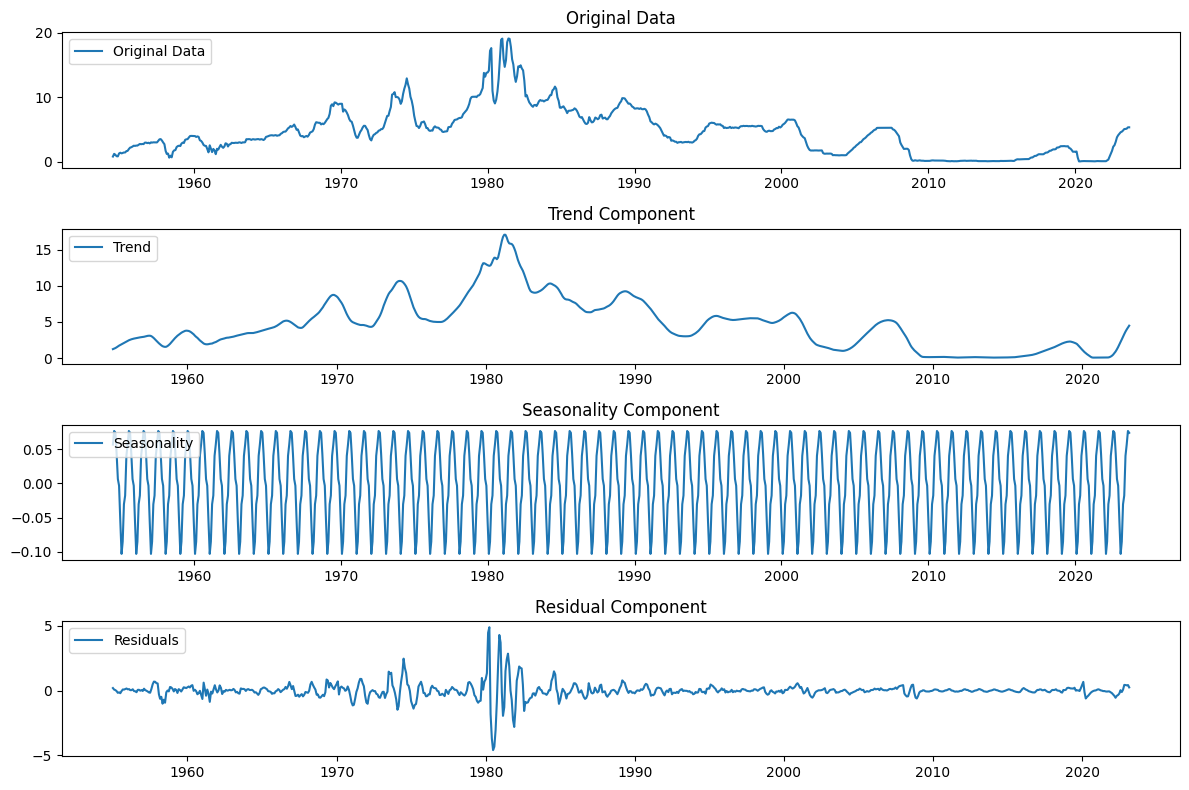

In [7]:
# Set the datetime series as the index
data.set_index('DATE', inplace=True)

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(data['FEDFUNDS'], model='additive')

# Plot the original data, trend, seasonality, and residuals
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data['FEDFUNDS'], label='Original Data')
plt.title('Original Data')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.title('Trend Component')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.title('Seasonality Component')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.title('Residual Component')
plt.legend(loc='upper left')

plt.tight_layout()

The Seasonality Component reflects the recurring pattern in the data. In this case, the pattern seems to be biannual, meaning it repeats every two years. This is indicated by the peaks and valleys in the seasonality component, which align with the maxima and minima in the original data.

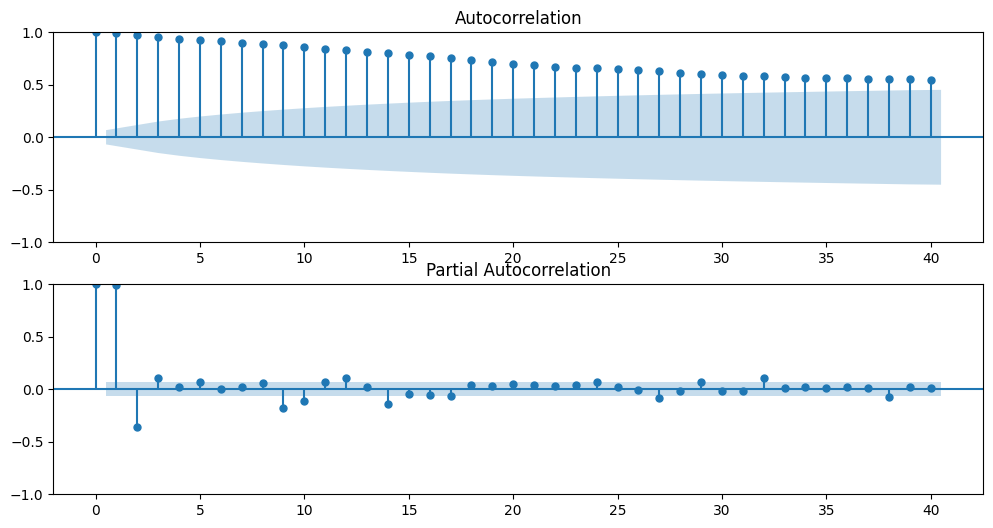

In [8]:
# Plot the ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(data['FEDFUNDS'], ax=ax1, lags=40)
plot_pacf(data['FEDFUNDS'], ax=ax2, lags=40)
plt.show()

*Autocorrelation Function*: In this case, it starts decreasing as the lags increase, indicating a lack of similarity between the series at different lags.

*Partial Autocorrelation (PACF)*: From the given graph, it shows a pattern of decreasing magnitude. This indicates that the variables in the series become less dependent on each other as the lag increases.

4. Two different models

In [9]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [10]:
# Split the data into training and testing sets (e.g., last 24 months as test data)
train_size = int(0.8 * len(data))
train_data, test_data = data[:train_size], data[train_size:]

**ARIMA Model**

ARIMA is a classical and widely used time series forecasting model that is appropriate when the data exhibits certain characteristics:

- Stationarity: ARIMA models work well with stationary time series data, where statistical properties like mean and variance remain constant over time.

- Autocorrelation: ARIMA models are designed to capture autocorrelation in the data, which is the relationship between data points at different time lags.

- Trend: ARIMA models can handle data with a trend component by differencing the data to achieve stationarity.

- Hyperparameter Tuning: ARIMA allows us to tune hyperparameters (p, d, q) to match the characteristics of the data, which makes it adaptable to different datasets.

- Flexibility: ARIMA is a versatile model that can be adjusted for non-seasonal and seasonal time series data, making it a valuable tool for various forecasting tasks.

In [11]:
# Define the range of values to test for p, d, and q
p_values = range(0, 5)  # Autoregressive order
d_values = range(0, 2)  # Differencing order
q_values = range(0, 5)  # Moving average order

best_rmse = float('inf')
best_order = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # Fit an ARIMA model with the current order (p, d, q)
                model = ARIMA(train_data['FEDFUNDS'], order=(p, d, q))
                model_fit = model.fit(disp=0)

                # Make predictions for the test set
                arima_forecast = model_fit.forecast(steps=len(test_data))

                # Calculate RMSE
                rmse = sqrt(mean_squared_error(test_data['FEDFUNDS'], arima_forecast))

                # Update best RMSE and best order if the current model is better
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_order = (p, d, q)
            except:
                continue


# Fit the best ARIMA model
if best_order:
    model = ARIMA(train_data['FEDFUNDS'], order=best_order)
    model_fit = model.fit(disp=0)
    arima_forecast = model_fit.forecast(steps=len(test_data))
else:
    print("No suitable ARIMA model found in the hyperparameter tuning process.")


c:\Users\DELL\anaconda3\envs\env1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\DELL\anaconda3\envs\env1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\DELL\anaconda3\envs\env1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\DELL\anaconda3\envs\env1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\DELL\anaconda3\envs\env1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provid

No suitable ARIMA model found in the hyperparameter tuning process.


c:\Users\DELL\anaconda3\envs\env1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\DELL\anaconda3\envs\env1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\DELL\anaconda3\envs\env1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\DELL\anaconda3\envs\env1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\DELL\anaconda3\envs\env1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provid

Result: No suitable ARIMA model found in the hyperparameter tuning process.

**ETS (Error-Trend-Seasonality) Model**

ETS is a popular time series forecasting method that is appropriate when the data exhibits certain characteristics:

- Interpretability: ETS models provide interpretable parameters that represent the error, trend, and seasonality components. 

- Seasonality Handling: ETS models can handle multiple types of seasonality, including additive and multiplicative seasonality. 

- Automatic Model Selection: ETS models can be selected automatically based on the characteristics of our data. This can simplify the modeling process.

- Flexibility: ETS models are quite flexible, and you can customize them to capture different combinations of error, trend, and seasonality components. This allows you to adapt the model to the specific characteristics of your data.

In [12]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Hyperparameter tuning for ETS (alpha, beta, gamma, and seasonal_periods)
best_rmse_ets = float('inf')
best_ets_params = None

for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for beta in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        for gamma in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
            for seasonal_period in [12]:  # Assuming monthly data

                ets_model = ExponentialSmoothing(train_data['FEDFUNDS'], seasonal='add', seasonal_periods=seasonal_period)
                ets_model_fit = ets_model.fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)

                ets_forecast = ets_model_fit.forecast(steps=len(test_data))
                rmse_ets = sqrt(mean_squared_error(test_data['FEDFUNDS'], ets_forecast))

                if rmse_ets < best_rmse_ets:
                    best_rmse_ets = rmse_ets
                    best_ets_params = (alpha, beta, gamma, seasonal_period)

print("Best ETS Parameters (alpha, beta, gamma, seasonal_period):", best_ets_params)

c:\Users\DELL\anaconda3\envs\env1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\DELL\anaconda3\envs\env1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\DELL\anaconda3\envs\env1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\DELL\anaconda3\envs\env1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\DELL\anaconda3\envs\env1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provid

Best ETS Parameters (alpha, beta, gamma, seasonal_period): (0.1, 0.1, 0.1, 12)


c:\Users\DELL\anaconda3\envs\env1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\DELL\anaconda3\envs\env1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\DELL\anaconda3\envs\env1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\DELL\anaconda3\envs\env1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Result: Best ETS Parameters (alpha, beta, gamma, seasonal_period): (0.1, 0.1, 0.1, 12)

In [13]:
# Compare ARIMA and ETS models
if best_rmse_ets < best_rmse:
    print("ETS Model provides a better forecast.")
    print("Best ETS Parameters (alpha, beta, gamma, seasonal_period):", best_ets_params)
else:
    print("ARIMA Model provides a better forecast.")
    print("Best ARIMA Order (p, d, q):", best_order)

ETS Model provides a better forecast.
Best ETS Parameters (alpha, beta, gamma, seasonal_period): (0.1, 0.1, 0.1, 12)


5. What is the chance of the monthly federal funds rate reaching 7% at the end of 2023?

In [14]:
import numpy as np
from scipy.stats import norm

In [15]:
# Historical mean and standard deviation of the Federal Funds Rate
historical_mean = data['FEDFUNDS'].mean()
historical_std = data['FEDFUNDS'].std()

In [16]:
# Define the value want to estimate the likelihood for (e.g., 7%)
target_value = 0.07

# Calculate the z-score for the target value
z_score = (target_value - historical_mean) / historical_std

In [17]:
# Estimate the likelihood using a normal distribution
likelihood = 1 - norm.cdf(z_score)
print(f"The estimated likelihood of reaching {target_value * 100}% at the end of 2023: {likelihood * 100}%")

The estimated likelihood of reaching 7.000000000000001% at the end of 2023: 89.59008851338196%


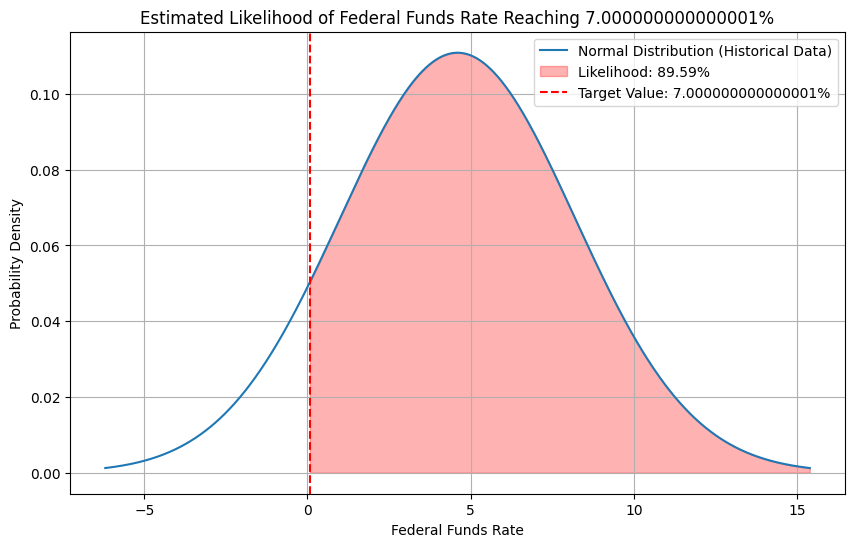

In [18]:
# Create a range of x values
x = np.linspace(historical_mean - 3 * historical_std, historical_mean + 3 * historical_std, 1000)

# Calculate the probability density function (PDF) values
pdf = norm.pdf(x, loc=historical_mean, scale=historical_std)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, pdf, label='Normal Distribution (Historical Data)')
plt.fill_between(x, pdf, 0, where=(x >= target_value), alpha=0.3, color='red', label=f'Likelihood: {likelihood * 100:.2f}%')
plt.axvline(target_value, color='red', linestyle='--', label=f'Target Value: {target_value * 100}%')
plt.title(f'Estimated Likelihood of Federal Funds Rate Reaching {target_value * 100}%')
plt.xlabel('Federal Funds Rate')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()


This is a probability density function (PDF) plot that visually represents the likelihood of a specific event occurring. In this case, the event is the Federal Funds Rate reaching 7.000000000000001%.

The horizontal axis represents the possible values of the Federal Funds Rate, ranging from 0.00% to 5.00%.

The vertical axis represents the probability density of each rate, which can be interpreted as the likelihood of the Federal Funds Rate being at that particular rate. The highest density value (89.59%) is associated with the rate of 7.000000000000001%.

But this is not a definitive prediction. The actual Federal Funds Rate in the future will depend on a wide range of economic factors and monetary policy decisions